In [203]:
from IPython.display import display, display_html
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [ ]:
import sys
!{sys.executable} -m pip install ipywidgets lxml

In [254]:


dropdown=widgets.Dropdown(
  options=['microsoft','cisco','lenovo','intel','amd'],
  value='microsoft',
  disabled=False,
)


datepicker=widgets.DatePicker(
    description='Pick a Date',
    disabled=False
)

In [265]:
from IPython.core.display import display, display_html, HTML
import ipywidgets as widgets
import requests
from datetime import date, timedelta
from concurrent.futures import ThreadPoolExecutor
import lxml.html
import re

#date
#https://services.nvd.nist.gov/rest/json/cves/1.0?pubStartDate=2020-02-22T00:00:00:000%20UTC
#keyword
#https://services.nvd.nist.gov/rest/json/cves/1.0?keyword=
#date & keyword
#https://services.nvd.nist.gov/rest/json/cves/1.0?keyword=microsoft&pubStartDate=2020-02-22T00:00:00:000%20UTC
#cve
#https://nvd.nist.gov/vuln/detail/


def group(lst, key, value=None):
    result = defaultdict(list)
    for i in lst:
        result[key(i) if callable(key) else i[key]].append(value(i) if callable(value) else i[value] if value else i)
    return result

def scrape_cve(cve_id):
    data_ids = ["vuln-description", "vuln-cvss3-panel-score"]
    nvd_cve_url = f"https://nvd.nist.gov/vuln/detail/{cve_id}"
    #print( nvd_cve_url)
    cve_doc = lxml.html.fromstring(requests.get(nvd_cve_url).content)
    try:
      extracted = {id: cve_doc.xpath(f"//*[@data-testid='{id}']/text()")[0] for id in data_ids}
      #print((extracted["vuln-description"]).split(",")[0])
      try:
        cvscore=float(re.match("(\d+\.\d+).*", extracted["vuln-cvss3-panel-score"]).group(1))
      except:
        cvscore=0.0
      return {
        "id": cve_id,
        "url": nvd_cve_url,
        "description": extracted["vuln-description"],
        "aka": (extracted["vuln-description"]).split(",")[0],
        "cvss_score": cvscore
      }
    except:
      data_ids2 = ["vuln-description","vuln-cvss3-panel-score-na"]
      extracted = {id: cve_doc.xpath(f"//*[@data-testid='{id}']/text()") for id in data_ids2}
    return {
        "id": cve_id,
        "url": nvd_cve_url,
        "description": extracted["vuln-description"][0],
        "aka": (extracted["vuln-description"][0]).split(",")[0],
        "cvss_score": 0.0
    }

cvss_severity_colors = {
    "None": None,
    "Low": "green",
    "Medium": "#FFA53F",
    "High": "#FF4F4F",
    "Critical": "mediumorchid"  
}
cvss_severity_matrix = [
    ("None", 0.0, 0.0),
    ("Low", 0.1, 3.9),
    ("Medium", 4.0, 6.9),
    ("High", 7.0, 8.9),
    ("Critical", 9.0, 10.0)
]

def cvss_severity(score):
    for severity, from_score, to_score in cvss_severity_matrix:
        if int(from_score*10) <= int(score*10) <= int(to_score*10):
            return severity
        
def table(columns, rows):
    def table_cell_attrs(column, row=None):
        attrs = {}
        if "attrs" in column:
            for k, v in column["attrs"].items():
                if callable(v):
                    if row:
                        attrs[k] = v(row)
                else:
                     attrs[k] = v    
            if attrs:
                return " " + " ".join(f'{k}="{v}"' for k, v in attrs.items())
        return ""
    def table_header_cells():
        return [f"<th{table_cell_attrs(column)}>{column['title']}</th>" for column in columns]
    def table_body_cells(row):
        return [f"<td{table_cell_attrs(column,row)}>{column['processor'](row[column['key']]) if 'processor' in column else row[column['key']]}</td>" for column in columns]
    def table_row(cells):
        return f"<tr>{''.join(cells)}</tr>"
    return f"""<table width="100%">
    <thead>{table_row(table_header_cells())}</thead>
    <tbody>{''.join(table_row(table_body_cells(row)) for row in rows)}</tbody>
</table>"""


date_t = date.today().strftime("%Y-%m-%d")
date_minus = (date.today() - timedelta(days=10)).strftime("%Y-%m-%d")
#print("yyyy-MM-dd'T'HH:mm:ss:SSS z")
#print(date_t)

#software="microsoft"
display("Choose a vendor/product")
display(dropdown)
display(datepicker)

try:
  data = requests.get(
      "https://services.nvd.nist.gov/rest/json/cves/1.0?keyword={}&pubStartDate={}T00:00:00:000%20UTC&resultsPerPage=100".format(dropdown.value,datepicker.value),
      headers={
          'Accept': 'application/json'
      }).json()
except:
  print("something went wrong!")
  

cve_ids=[]
if (data["totalResults"] > 0):
  for i in range(data["totalResults"]):
    cve_ids.append(data["result"]["CVE_Items"][i]["cve"]["CVE_data_meta"]["ID"])
else:
  display('No CVEs found!')

'Choose a vendor/product'

Dropdown(index=2, options=('microsoft', 'cisco', 'lenovo', 'intel', 'amd'), value='lenovo')

DatePicker(value=datetime.date(2020, 2, 1), description='Pick a Date')

In [266]:
if (data["totalResults"] > 0):
  display(HTML("<h1>" + (dropdown.value[:1]).upper() + (dropdown.value[1:]) + " CVE Feed from "+ date_minus+"</h1>"))
  with ThreadPoolExecutor(max_workers=3) as executor:
    cves = sorted(executor.map(scrape_cve, cve_ids), key=lambda x: x["cvss_score"], reverse=True)

    display(HTML(table(
    [
        {
            "key": "id", 
            "title": "CVE", 
            "attrs": {"width": "15%"}
        },
        {
            "key": "cvss_score", 
            "title": "Severity (CVSSv3)", 
            "attrs": {"width": "5%", "bgcolor": lambda r: cvss_severity_colors[cvss_severity(r["cvss_score"])]}
        },
        {
            "key": "aka", 
            "title": "Title", 
            "attrs": {"width": "20%"}
        },
        {
            "key": "description", 
            "title": "Description"
        },
        {
            "key": "url", 
            "title": "URL"
        }
    ], 
    cves
  )))
else:
  print("")

CVE,Severity (CVSSv3),Title,Description,URL
CVE-2019-6194,5.5,An XML External Entity (XXE) processing vulnerability was reported in Lenovo XClarity Administrator (LXCA) versions prior to 2.6.6 that could allow information disclosure.,An XML External Entity (XXE) processing vulnerability was reported in Lenovo XClarity Administrator (LXCA) versions prior to 2.6.6 that could allow information disclosure.,https://nvd.nist.gov/vuln/detail/CVE-2019-6194
CVE-2019-19757,0.0,An internal product security audit of Lenovo XClarity Administrator (LXCA) discovered a Document Object Model (DOM) based cross-site scripting vulnerability in versions prior to 2.6.6 that could allow JavaScript code to be executed in the user's web browser if a specially crafted link is visited. The JavaScript code is executed on the user's system,"An internal product security audit of Lenovo XClarity Administrator (LXCA) discovered a Document Object Model (DOM) based cross-site scripting vulnerability in versions prior to 2.6.6 that could allow JavaScript code to be executed in the user's web browser if a specially crafted link is visited. The JavaScript code is executed on the user's system, not executed on LXCA itself.",https://nvd.nist.gov/vuln/detail/CVE-2019-19757
CVE-2019-6193,0.0,An information disclosure vulnerability was reported in Lenovo XClarity Administrator (LXCA) versions prior to 2.6.6 that could allow unauthenticated access to some configuration files which may contain usernames,"An information disclosure vulnerability was reported in Lenovo XClarity Administrator (LXCA) versions prior to 2.6.6 that could allow unauthenticated access to some configuration files which may contain usernames, license keys, IP addresses, and encrypted password hashes.",https://nvd.nist.gov/vuln/detail/CVE-2019-6193
CVE-2019-6195,0.0,An authorization bypass exists in Lenovo XClarity Controller (XCC) versions prior to 3.08 CDI340V,"An authorization bypass exists in Lenovo XClarity Controller (XCC) versions prior to 3.08 CDI340V, 3.01 TEI392O, 1.71 PSI328N where a valid authenticated user with lesser privileges may be granted read-only access to higher-privileged information if 1) “LDAP Authentication Only with Local Authorization” mode is configured and used by XCC, and 2) a lesser privileged user logs into XCC within 1 minute of a higher privileged user logging out. The authorization bypass does not exist when “Local Authentication and Authorization” or “LDAP Authentication and Authorization” modes are configured and used by XCC.",https://nvd.nist.gov/vuln/detail/CVE-2019-6195
CVE-2019-19758,0.0,A vulnerability in the web interface of Lenovo EZ Media & Backup Center,"A vulnerability in the web interface of Lenovo EZ Media & Backup Center, ix2 & ix2-dl version 4.1.406.34763 and prior could allow an unauthenticated, remote attacker to redirect a user to an untrusted web page.",https://nvd.nist.gov/vuln/detail/CVE-2019-19758
CVE-2019-6190,0.0,Lenovo was notified of a potential denial of service vulnerability,"Lenovo was notified of a potential denial of service vulnerability, affecting various versions of BIOS for Lenovo Desktop, Desktop - All in One, and ThinkStation, that could cause PCRs to be cleared intermittently after resuming from sleep (S3) on systems with Intel TXT enabled.",https://nvd.nist.gov/vuln/detail/CVE-2019-6190


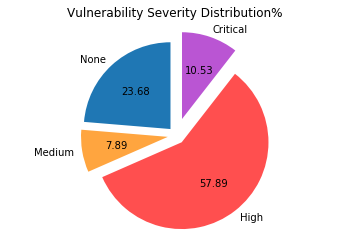

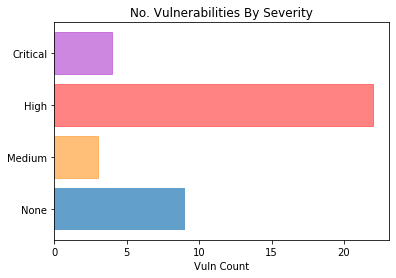

In [264]:
import matplotlib.pyplot as plotter
from collections import defaultdict

if (data["totalResults"] > 0):
  grouped_cves = group(cves, lambda x: cvss_severity(x["cvss_score"]))

  severities = list([i[0] for i in cvss_severity_matrix if i[0] in grouped_cves])
  severity_counts = [len(grouped_cves.get(k,[])) for k in severities]

  explode_severities = {
    "None": 0.1,
    "Low": 0.1,
    "Medium": 0.1,
    "High": 0.1,
    "Critical": 0.2
  }

  figureObject, axesObject = plotter.subplots()
  pie=axesObject.pie(severity_counts, 
        explode=[explode_severities[k] for k in severities],
        labels=severities,
        autopct='%1.2f',
        colors=[cvss_severity_colors[k] for k in severities],
        startangle=90)
  axesObject.axis('equal')
  plotter.title('Vulnerability Severity Distribution%')
  plotter.show()

  figureObject, axesObject = plotter.subplots()
  barlist = axesObject.barh(severities,
        severity_counts,
        0.8,
        alpha = 0.7,
        color = 'blue',
        label = 'Vulns')
  for i, s in enumerate(severities):
    barlist[i].set_color(cvss_severity_colors[s])
  axesObject.set_xlabel('Vuln Count')
  plotter.title('No. Vulnerabilities By Severity')
  plotter.show()
else:
  print("")